In [2]:
import CreatePIDsDF
import random as random
import math
import matplotlib.pylab as plt

# Read in File

In [3]:
filename = "train.csv"
tsObj = CreatePIDsDF.CreatePIDsDF(filename)
df = tsObj['ts']

In [4]:
df.head()

,Time (sec),Latitude (deg),Longitude (deg),Vehicle speed (MPH),Fuel rate (gal/hr),Engine RPM (RPM),Time since engine start (sec),Acceleration (ft/s²),Acceleration (Avg) (ft/s²),Intake manifold absolute pressure (inHg),...,Ambient air temperature (F),Barometric pressure (inHg),Driver's demand engine - percent torque (%),Actual engine - percent torque (%),Engine reference torque (lb•ft),Mass air flow rate (lb/min),Trip Duration (min),Trip Distance (miles),Altitude (ft),Absolute throttle position (%)
0,0.000,34.02115,-118.2907,0.0,0.716810,1100.75,28.0,0.0,0.0,17.61656,...,0.0,29.5301,0.0,0.0,0.0,0.0,0.032436,0.0,167.3228,18.03922
1,0.908,34.02118,-118.2907,0.0,0.718569,1089.00,28.0,0.0,0.0,17.72420,...,0.0,29.5301,0.0,0.0,0.0,0.0,0.048785,0.0,150.9186,18.03922
2,1.930,34.02119,-118.2907,0.0,0.686906,1067.00,28.0,0.0,0.0,17.35057,...,0.0,29.5301,0.0,0.0,0.0,0.0,0.062159,0.0,137.7953,18.03922
3,2.914,34.02119,-118.2907,0.0,0.678111,1045.25,28.0,0.0,0.0,17.39642,...,0.0,29.5301,0.0,0.0,0.0,0.0,0.076915,0.0,134.5144,18.03922
4,3.908,34.02119,-118.2907,0.0,0.657882,1032.00,33.0,0.0,0.0,17.24543,...,0.0,29.5301,0.0,0.0,0.0,0.0,0.097752,0.0,137.7953,17.64706


# K-Means Clustering (using LB_Keogh distance) on each TS in File

In [5]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return math.sqrt(LB_sum)

def DTWDistance(s1, s2,w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return math.sqrt(DTW[len(s1)-1, len(s2)-1])

In [27]:
def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(list(data),num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]

        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]

    return centroids

In [28]:
dfArray = df.as_matrix(columns=df.columns[1:])

In [29]:
centroids=k_means_clust(dfArray,4,10,4)

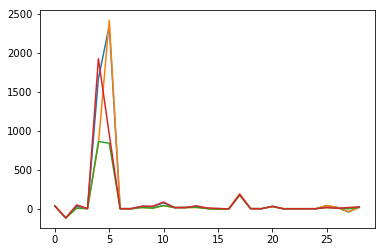

In [30]:
for i in centroids:

    plt.plot(i)

plt.show()

# KNN
### use KNN to train with one day's driving data to predict another next day's driving data

In [40]:
from sklearn.metrics import classification_report

def knn(train,test,w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        print(ind)
        for j in train:
            if LB_Keogh(i[:-1],j[:-1],5)<min_dist:
                dist=DTWDistance(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(closest_seq[-1])
    #return classification_report(test[:,-1],preds)
    return preds


In [32]:
train = dfArray
test = CreatePIDsDF.CreatePIDsDF('test.csv')['ts'].as_matrix(columns=df.columns[1:])

too many columns to train on... going to select just a few...
I'll select a few at random now, but will probably try PCA later to see what more relevant ones to keep 

In [33]:
df.columns

Index(['Time (sec)', 'Latitude (deg)', 'Longitude (deg)',
       'Vehicle speed (MPH)', 'Fuel rate (gal/hr)', 'Engine RPM (RPM)',
       'Time since engine start (sec)', 'Acceleration (ft/s²)',
       'Acceleration (Avg) (ft/s²)',
       'Intake manifold absolute pressure (inHg)', 'Engine Power (hp)',
       'Engine Torque (lb•ft)', 'A/F Commanded', 'A/F Actual',
       'Instant fuel economy (MPG)', 'Magnetometer Z (µT)',
       'Magnetometer Y (µT)', 'Magnetometer X (µT)',
       'Engine coolant temperature (F)',
       'Fuel/Air commanded equivalence ratio', 'Ambient air temperature (F)',
       'Barometric pressure (inHg)',
       'Driver's demand engine - percent torque (%)',
       'Actual engine - percent torque (%)', 'Engine reference torque (lb•ft)',
       'Mass air flow rate (lb/min)', 'Trip Duration (min)',
       'Trip Distance (miles)', 'Altitude (ft)',
       'Absolute throttle position (%)'],
      dtype='object')

In [49]:
train_trim = df.as_matrix(columns=df.columns[[3,4,5,9,10,11,12,13]])[0:500]
test_trim = CreatePIDsDF.CreatePIDsDF('test.csv')['ts'].as_matrix(columns=df.columns[[3,4,5,9,10,11,12,13]])[0:500]

In [50]:
results = knn(train_trim,test_trim,4)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [68]:
print(classification_report(test_trim[:,0],results))

ValueError: Unknown label type: (array([ 15.53428 ,  15.53428 ,  16.15565 ,  14.91291 ,  13.04879 ,
         9.941939,   8.077826,   4.97097 ,   4.97097 ,   7.456454,
        11.18468 ,  10.56331 ,  10.56331 ,  13.04879 ,  14.29154 ,
        17.39839 ,  18.64114 ,  18.64114 ,  18.01976 ,  16.77702 ,
        14.91291 ,  11.80605 ,   9.941939,  10.56331 ,  11.80605 ,
        11.80605 ,  14.91291 ,  16.77702 ,  18.01976 ,  18.01976 ,
        18.01976 ,  18.01976 ,  16.15565 ,  12.42742 ,  11.80605 ,
        11.18468 ,  11.18468 ,  12.42742 ,  17.39839 ,  19.88388 ,
        19.88388 ,  21.12662 ,  21.12662 ,  18.64114 ,  14.29154 ,
        11.80605 ,  11.18468 ,   9.320568,   9.320568,   9.320568,
         9.320568,  10.56331 ,  10.56331 ,  13.04879 ,  12.42742 ,
        11.18468 ,  12.42742 ,  12.42742 ,  13.67017 ,  12.42742 ,
        10.56331 ,   8.699197,   5.592341,   4.97097 ,   8.077826,
        10.56331 ,   9.941939,   8.699197,   6.213712,   3.728227,
         5.592341,   7.456454,  11.80605 ,  15.53428 ,  18.64114 ,
        19.88388 ,  21.12662 ,  22.36936 ,  20.50525 ,  19.88388 ,
        16.77702 ,  11.18468 ,   9.320568,   9.320568,   6.835083,
         4.349598,   1.864114,   1.864114,   2.485485,   4.349598,
         6.835083,   9.320568,  11.80605 ,  14.29154 ,  15.53428 ,
        18.01976 ,  16.77702 ,   9.941939,   6.835083,   4.349598,
         3.106856,   3.106856,   4.349598,  10.56331 ,  13.04879 ,
        18.64114 ,  21.74799 ,  21.12662 ,  21.12662 ,  19.26251 ,
        15.53428 ,  10.56331 ,   9.320568,  11.18468 ,  12.42742 ,
         8.077826,   8.699197,  10.56331 ,  13.67017 ,  16.15565 ,
        14.91291 ,  13.04879 ,   8.077826,   3.106856,   1.864114,
         1.864114,   2.485485,   8.699197,   9.941939,  11.18468 ,
        11.18468 ,   9.320568,   8.077826,   7.456454,   5.592341,
         4.97097 ,   4.349598,   1.864114,   1.864114,   1.864114,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         3.728227,   5.592341,   5.592341,   4.97097 ,   5.592341,
         7.456454,   7.456454,   8.699197,  11.18468 ,  13.67017 ,
        13.67017 ,  13.67017 ,  13.67017 ,  15.53428 ,  18.01976 ,
        19.26251 ,  21.12662 ,  24.85485 ,  29.20445 ,  30.44719 ,
        30.44719 ,  30.44719 ,  29.82582 ,  29.20445 ,  28.58307 ,
        27.34033 ,  25.47622 ,  22.99073 ,  19.88388 ,  16.15565 ,
        11.80605 ,   6.835083,   5.592341,   1.864114,   1.864114,
         1.864114,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   3.106856,   7.456454,  12.42742 ,
        16.15565 ,  18.01976 ,  19.88388 ,  23.6121  ,  26.71896 ,
        28.58307 ,  28.58307 ,  31.06856 ,  31.06856 ,  31.06856 ,
        31.06856 ,  31.68993 ,  30.44719 ,  29.82582 ,  29.82582 ,
        29.20445 ,  27.9617  ,  24.85485 ,  21.74799 ,  19.88388 ,
        18.64114 ,  18.01976 ,  19.26251 ,  20.50525 ,  21.12662 ,
        22.36936 ,  23.6121  ,  22.99073 ,  21.74799 ,  18.64114 ,
        16.15565 ,  14.91291 ,  13.04879 ,  11.80605 ,  12.42742 ,
        12.42742 ,  13.67017 ,  14.91291 ,  16.15565 ,  19.26251 ,
        23.6121  ,  24.85485 ,  26.09759 ,  26.71896 ,  27.9617  ,
        29.20445 ,  30.44719 ,  30.44719 ,  29.82582 ,  29.82582 ,
        29.82582 ,  29.82582 ,  29.82582 ,  29.20445 ,  27.34033 ,
        25.47622 ,  21.74799 ,  18.64114 ,  18.01976 ,  18.01976 ,
        19.26251 ,  19.26251 ,  18.64114 ,  21.12662 ,  23.6121  ,
        23.6121  ,  24.85485 ,  24.85485 ,  24.23348 ,  23.6121  ,
        21.74799 ,  19.88388 ,  18.64114 ,  14.91291 ,  11.80605 ,
         6.213712,   3.728227,   1.864114,   1.864114,   1.864114,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   2.485485,   8.077826,  14.29154 ,  14.29154 ,
        14.91291 ,  14.91291 ,  16.15565 ,  17.39839 ,  21.74799 ,
        25.47622 ,  27.9617  ,  28.58307 ,  28.58307 ,  28.58307 ,
        29.82582 ,  29.82582 ,  29.20445 ,  27.34033 ,  22.99073 ,
        21.12662 ,  20.50525 ,  21.74799 ,  24.85485 ,  29.20445 ,
        32.3113  ,  37.90364 ,  39.76776 ,  42.25324 ,  43.49598 ,
        45.98147 ,  47.22421 ,  49.70969 ,  48.46695 ,  47.84558 ,
        47.84558 ,  50.33107 ,  50.95244 ,  53.43792 ,  54.68066 ,
        55.92341 ,  57.16615 ,  58.40889 ,  59.65163 ,  60.27301 ,
        61.51575 ,  62.13712 ,  61.51575 ,  62.13712 ,  62.13712 ,
        62.13712 ,  63.37986 ,  63.37986 ,  64.6226  ,  63.37986 ,
        62.75849 ,  58.40889 ,  55.92341 ,  53.43792 ,  52.19518 ,
        50.33107 ,  49.70969 ,  49.70969 ,  49.70969 ,  52.19518 ,
        52.81655 ,  52.81655 ,  54.05929 ,  54.68066 ,  55.92341 ,
        56.54478 ,  56.54478 ,  57.78752 ,  57.16615 ,  56.54478 ]), [14.38687, 14.691850000000001, 14.691850000000001, 14.708819999999999, 14.57263, 14.65211, 14.47752, 13.907310000000001, 13.93455, 14.29266, 14.47082, 14.986549999999999, 14.43778, 13.40408, 14.4994, 14.546279999999999, 15.17141, 14.73784, 14.36321, 13.453200000000001, 14.690060000000001, 14.80348, 13.907310000000001, 14.986549999999999, 14.48466, 14.6088, 14.710599999999999, 15.018700000000001, 14.73784, 13.30719, 14.61862, 14.548069999999999, 14.640940000000001, 14.987439999999999, 14.42394, 14.93967, 14.384639999999999, 15.39467, 13.33353, 14.63425, 14.63246, 14.515919999999999, 15.060230000000001, 14.557, 14.622640000000001, 14.70167, 14.950379999999999, 14.860189999999999, 14.533329999999999, 14.76061, 14.80348, 14.4543, 14.710599999999999, 14.281940000000001, 14.761509999999999, 14.73203, 14.47395, 14.98968, 14.987439999999999, 14.65479, 14.622640000000001, 14.01582, 14.84188, 14.384639999999999, 14.048859999999999, 14.56861, 14.55789, 14.55209, 14.773110000000001, 14.950379999999999, 14.63514, 14.89859, 14.398479999999999, 14.65479, 14.00108, 13.91981, 14.59808, 15.05621, 14.73114, 13.453200000000001, 14.2547, 14.6472, 14.690060000000001, 14.882059999999999, 14.690060000000001, 14.56861, 14.63916, 14.63916, 15.17543, 14.75257, 14.69319, 14.63514, 14.63916, 14.63425, 14.81241, 14.515919999999999, 18.038959999999999, 14.66952, 15.41342, 14.71462, 14.740069999999999, 14.43778, 14.32793, 14.66461, 14.690950000000001, 14.66461, 14.65077, 14.761509999999999, 14.05958, 14.010899999999999, 14.950379999999999, 13.40408, 14.607010000000001, 14.557, 14.55209, 15.016909999999999, 14.607010000000001, 14.32793, 14.63246, 13.30719, 14.56861, 14.653, 14.773110000000001, 14.740069999999999, 14.773110000000001, 15.159800000000001, 14.47662, 14.96199, 14.691850000000001, 14.73114, 14.55209, 14.56861, 16.298870000000001, 13.768890000000001, 14.84188, 14.627549999999999, 14.623530000000001, 14.740069999999999, 14.63916, 14.76642, 14.63916, 14.63916, 14.63916, 14.66952, 14.63916, 14.63916, 14.63916, 14.66952, 14.66952, 14.59808, 14.63916, 14.63916, 14.76642, 14.63916, 14.63916, 14.63916, 14.66952, 14.63916, 14.63916, 14.740069999999999, 14.66952, 14.63916, 14.63916, 14.63514, 14.19308, 14.72935, 14.72935, 14.72935, 14.547180000000001, 14.726229999999999, 14.726229999999999, 14.660589999999999, 14.740069999999999, 14.63157, 14.68113, 14.740069999999999, 14.68113, 14.68113, 14.571730000000001, 14.621740000000001, 14.68113, 14.621740000000001, 14.621740000000001, 14.68113, 14.621740000000001, 14.658799999999999, 14.72935, 14.69497, 14.72935, 14.72935, 14.61192, 14.510109999999999, 14.644959999999999, 14.660589999999999, 14.660589999999999, 14.690060000000001, 14.68113, 14.63157, 14.621740000000001, 14.621740000000001, 14.740069999999999, 14.621740000000001, 14.740069999999999, 14.621740000000001, 14.621740000000001, 14.56861, 14.24756, 14.72935, 14.61192, 14.61192, 14.69989, 14.61192, 14.643179999999999, 14.61951, 14.660589999999999, 14.61951, 14.644959999999999, 14.63246, 14.594060000000001, 14.76061, 14.660589999999999, 14.594060000000001, 14.594060000000001, 14.63157, 14.47752, 15.17543, 14.563700000000001, 14.84188, 14.63603, 14.75257, 14.47395, 14.969139999999999, 14.882960000000001, 14.67845, 14.578430000000001, 14.883850000000001, 14.42572, 14.4994, 14.368119999999999, 14.515919999999999, 14.690950000000001, 14.66461, 14.66461, 14.63425, 14.578430000000001, 18.038959999999999, 18.038959999999999, 14.756589999999999, 14.756589999999999, 14.495380000000001, 13.722899999999999, 14.05958, 13.722899999999999, 14.761509999999999, 14.76061, 14.55209, 14.494490000000001, 14.52753, 14.740069999999999, 14.65568, 14.63246, 14.72935, 14.69989, 14.69989, 14.69989, 14.726229999999999, 14.644959999999999, 14.61951, 14.41902, 14.555210000000001, 14.77713, 14.882960000000001, 14.4994, 14.21452, 14.65479, 14.58736, 14.21452, 14.5052, 14.00108, 14.59897, 14.546279999999999, 14.4994, 14.4994, 14.67845, 18.038959999999999, 18.038959999999999, 18.038959999999999, 13.021420000000001, 13.021420000000001, 14.495380000000001, 14.68604, 18.038959999999999, 18.038959999999999, 14.495380000000001, 14.691850000000001, 14.949490000000001, 14.398479999999999, 14.08145, 14.59629, 14.32793, 14.46903, 14.630229999999999, 14.61862, 14.68604, 13.965809999999999, 14.6472, 14.4543, 14.73427, 14.75257, 14.75257, 14.59629, 13.424620000000001, 14.67845, 14.607010000000001, 14.65479, 14.77535, 14.63514, 14.96199, 14.32793, 14.384639999999999, 14.546279999999999, 14.557, 14.38866, 13.37283, 13.345140000000001, 14.05377, 18.038959999999999, 18.038959999999999, 13.021420000000001, 14.05958, 14.81911, 14.741860000000001, 14.58915, 14.882960000000001, 16.557410000000001, 14.495380000000001, 14.249790000000001, 14.57263, 14.4994, 14.546279999999999, 14.51994, 13.862209999999999, 14.630229999999999, 18.038959999999999, 13.37283, 14.68604, 14.548069999999999, 14.653890000000001, 14.736050000000001, 14.69989, 14.867330000000001, 14.56861, 14.614599999999999, 14.720420000000001, 14.720420000000001, 14.740069999999999, 14.720420000000001, 14.740069999999999, 14.720420000000001, 14.720420000000001, 14.56861, 14.69497, 13.9216, 14.72935, 14.792759999999999, 14.792759999999999, 14.65568, 14.52172, 14.628439999999999, 14.613709999999999, 14.92404, 14.59897, 14.6204, 14.52753, 14.64987, 14.65211, 14.6088, 14.584239999999999, 14.64987, 14.56682, 14.61281, 14.640940000000001, 14.653890000000001, 14.63916, 14.63916, 14.63916, 14.63916, 14.63916, 14.63916, 14.63916, 14.63514, 14.24756, 14.65657, 14.609690000000001, 14.32213, 14.757490000000001, 14.66952, 14.53467, 14.628439999999999, 14.52172, 14.59004, 14.6655, 14.58915, 14.66863, 14.65211, 14.6012, 14.63916, 14.6012, 14.6012, 14.61951, 14.56682, 14.838749999999999, 14.63916, 14.56682, 14.6088, 14.63916, 14.61281, 14.584239999999999, 14.6655, 14.6012, 14.627549999999999, 14.6088, 14.6088, 14.63916, 14.657909999999999, 15.159800000000001, 14.63916, 14.66461, 14.546279999999999, 14.515919999999999, 14.691850000000001, 14.882960000000001, 15.016019999999999, 14.5052, 14.66461, 14.66461, 14.81241, 14.557, 14.644959999999999, 14.53914, 15.09506, 14.81911, 14.495380000000001, 14.024749999999999, 14.81911, 14.234159999999999, 14.5052, 14.66461, 14.66461, 14.66461, 14.66461, 14.66461, 14.66461, 14.66461, 14.66461, 14.66461, 14.66461, 14.81241, 14.578430000000001, 14.66461, 14.66461, 14.66461, 14.66461, 14.66461, 14.66461, 14.66461, 14.66461, 14.66461, 14.66461, 14.66461, 14.59897, 14.57263, 14.56593, 14.56593, 14.57263, 14.57263, 14.58736, 14.77535, 14.77535, 14.81241, 14.597189999999999, 14.024749999999999, 14.59986, 14.557, 14.578430000000001, 14.578430000000001, 14.398479999999999, 14.66461, 14.690950000000001, 14.690950000000001, 14.690950000000001, 14.5052, 14.57263, 14.384639999999999, 14.690950000000001, 14.77535, 14.73293, 14.024749999999999, 14.024749999999999, 14.024749999999999])

In [71]:
test_trim[:,0].values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [64]:
results

[14.38687,
 14.691850000000001,
 14.691850000000001,
 14.708819999999999,
 14.57263,
 14.65211,
 14.47752,
 13.907310000000001,
 13.93455,
 14.29266,
 14.47082,
 14.986549999999999,
 14.43778,
 13.40408,
 14.4994,
 14.546279999999999,
 15.17141,
 14.73784,
 14.36321,
 13.453200000000001,
 14.690060000000001,
 14.80348,
 13.907310000000001,
 14.986549999999999,
 14.48466,
 14.6088,
 14.710599999999999,
 15.018700000000001,
 14.73784,
 13.30719,
 14.61862,
 14.548069999999999,
 14.640940000000001,
 14.987439999999999,
 14.42394,
 14.93967,
 14.384639999999999,
 15.39467,
 13.33353,
 14.63425,
 14.63246,
 14.515919999999999,
 15.060230000000001,
 14.557,
 14.622640000000001,
 14.70167,
 14.950379999999999,
 14.860189999999999,
 14.533329999999999,
 14.76061,
 14.80348,
 14.4543,
 14.710599999999999,
 14.281940000000001,
 14.761509999999999,
 14.73203,
 14.47395,
 14.98968,
 14.987439999999999,
 14.65479,
 14.622640000000001,
 14.01582,
 14.84188,
 14.384639999999999,
 14.048859999999999,
